In [234]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra

# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import matplotlib.pyplot as plt
# import sklearn

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [235]:
# # Import training set
# df = pd.read_csv("/kaggle/input/autoam-car-price-prediction/train.csv")
# df_test = pd.read_csv("/kaggle/input/autoam-car-price-prediction/test.csv")

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import numpy as np

import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, cv
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import KBinsDiscretizer

In [237]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [238]:
df_temp = df.copy()

In [239]:
df_temp = df_temp.loc[~df_temp.duplicated()].reset_index(drop = True)

In [240]:
df_temp["running"] = df_temp["running"].apply(lambda x: int(x.split()[0]) if "km" in x else int(x.split()[0]) * 1.60934)
df_test["running"] = df_test["running"].apply(lambda x: int(x.split()[0]) if "km" in x else int(x.split()[0]) * 1.60934)

In [241]:
df_temp["log_running"] = np.log1p(df_temp["running"])
df_temp["running_per_motor"] = df_temp["log_running"]/df_temp["motor_volume"]
df_temp["running_per_year"] = df_temp["log_running"]/(2024 - df_temp["year"])

df_test["log_running"] = np.log1p(df_test["running"])
df_test["running_per_motor"] = df_test["log_running"]/df_test["motor_volume"]
df_test["running_per_year"] = df_test["log_running"]/(2024 - df_test["year"])

In [242]:
df_temp = pd.get_dummies(df_temp, dtype=int).reset_index(drop=True)
df_test = pd.get_dummies(df_test, dtype=int).reset_index(drop=True)

In [243]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(df_temp.drop("price", axis = 1), df_temp["price"], test_size = 0.2 )

# 4. Convert String to categories

In [244]:
for label, content in X_train.items():
    if pd.api.types.is_string_dtype(content):
        X_train[label] = content.astype("category").cat.as_ordered()
        
for label, content in X_test.items():
    if pd.api.types.is_string_dtype(content):
        X_test[label] = content.astype("category").cat.as_ordered()
        
for label, content in df_test.items():
    if pd.api.types.is_string_dtype(content):
        df_test[label] = content.astype("category").cat.as_ordered()

In [245]:
for label, content in X_train.items():
    if pd.api.types.is_string_dtype(content):
        X_train[label] = X_train[label].cat.codes

for label, content in X_test.items():
    if pd.api.types.is_string_dtype(content):
        X_test[label] = X_test[label].cat.codes
        
for label, content in df_test.items():
    if pd.api.types.is_string_dtype(content):
        df_test[label] = df_test[label].cat.codes

In [246]:
X_train

,year,running,motor_volume,log_running,running_per_motor,running_per_year,model_hyundai,model_kia,model_mercedes-benz,model_nissan,...,type_hatchback,type_minivan / minibus,type_pickup,type_sedan,type_suv,status_crashed,status_excellent,status_good,status_new,status_normal
63,2014,92215.000,2.0,11.431889,5.715944,1.143189,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
812,2022,4667.086,2.0,8.448504,4.224252,4.224252,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1156,2017,71000.000,2.0,11.170449,5.585225,1.595778,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1043,2002,260000.000,2.0,12.468441,6.234220,0.566747,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1589,2011,145000.000,1.8,11.884496,6.602498,0.914192,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,2018,83000.000,2.0,11.326608,5.663304,1.887768,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
1294,2017,70000.000,2.0,11.156265,5.578132,1.593752,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
860,2011,120000.000,2.0,11.695255,5.847628,0.899635,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1459,2017,130000.000,2.0,11.775297,5.887649,1.682185,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [247]:
X_test

,year,running,motor_volume,log_running,running_per_motor,running_per_year,model_hyundai,model_kia,model_mercedes-benz,model_nissan,...,type_hatchback,type_minivan / minibus,type_pickup,type_sedan,type_suv,status_crashed,status_excellent,status_good,status_new,status_normal
674,2020,62764.26,2.0,11.047157,5.523579,2.761789,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1627,2018,69000.00,2.0,11.141876,5.570938,1.856979,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
543,2019,104607.10,2.0,11.557976,5.778988,2.311595,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
506,2007,182000.00,1.6,12.111767,7.569855,0.712457,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
873,2014,191511.46,1.8,12.162708,6.757060,1.216271,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,2017,86000.00,2.0,11.362114,5.681057,1.623159,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
306,2017,120700.50,2.0,11.701076,5.850538,1.671582,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
192,2016,64373.60,2.0,11.072474,5.536237,1.384059,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
309,2021,14900.00,2.0,9.609184,4.804592,3.203061,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0


In [248]:
X_combined = pd.concat([X_train, X_test], ignore_index=True)

y_combined = pd.concat([y_train, y_test], ignore_index=True)

In [249]:
def draw_scatter(name, X_combined, y_combined):
    plt.scatter(X_combined[name], y_combined)
    plt.title(f'Scatter Plot between {name} and price')
    plt.xlabel(name)
    plt.ylabel('price')
    plt.show()

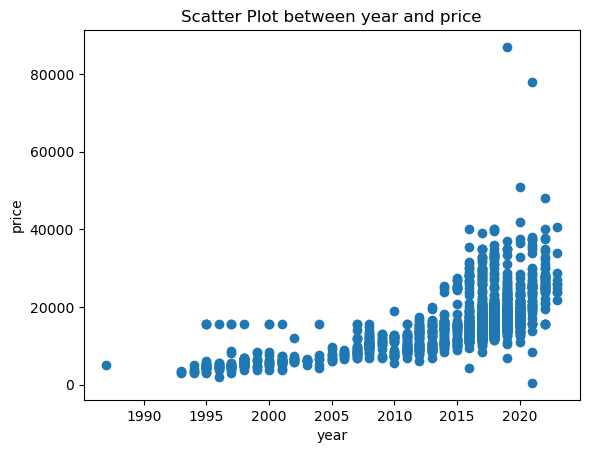

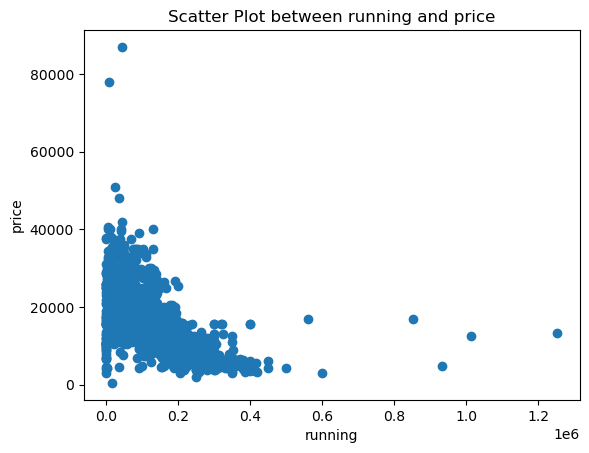

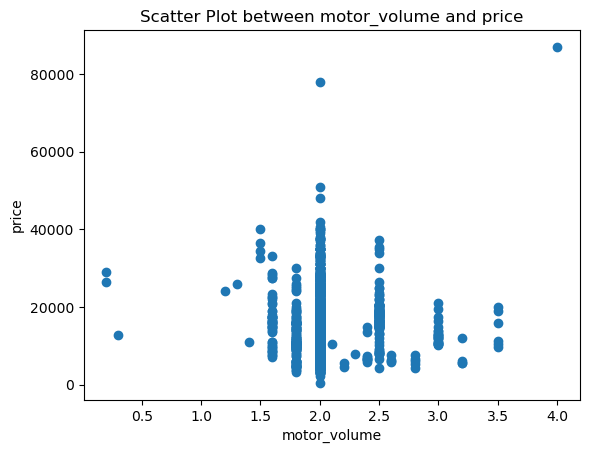

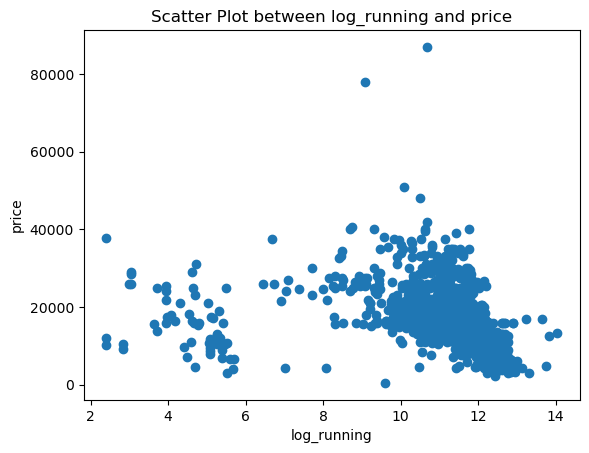

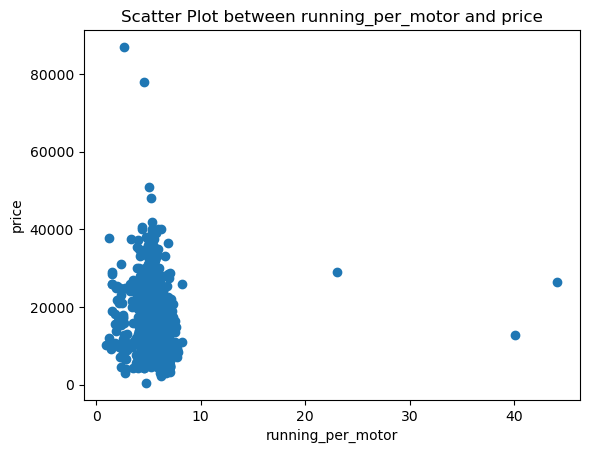

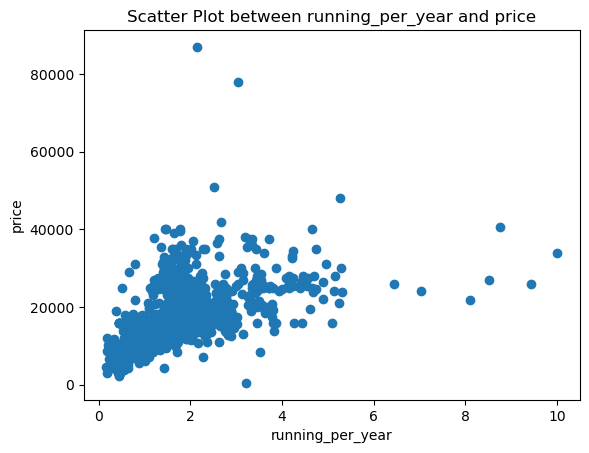

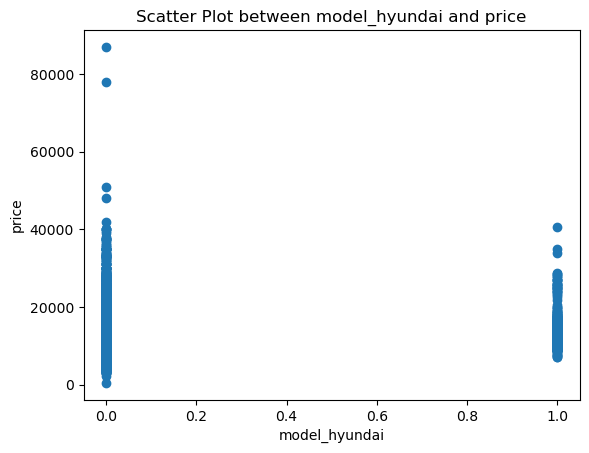

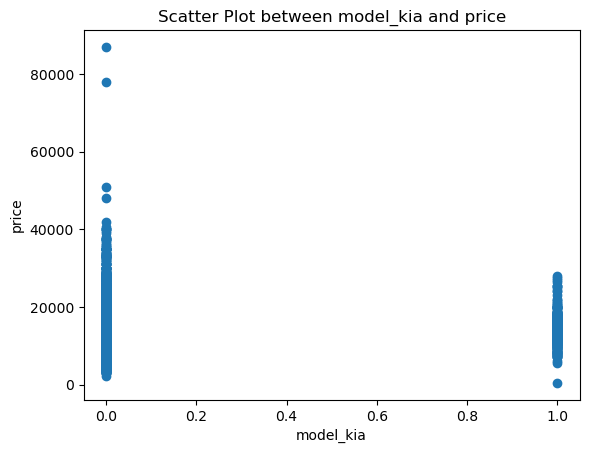

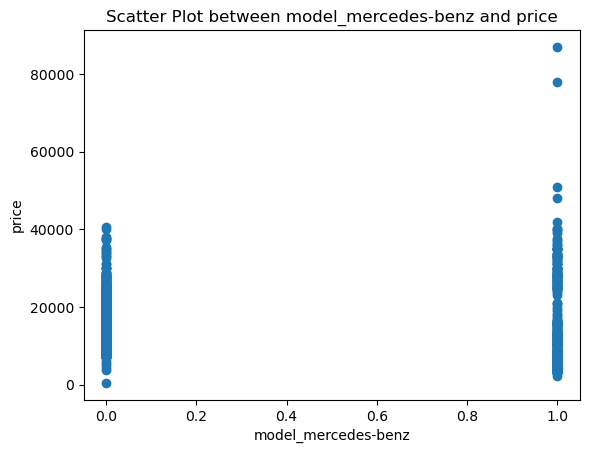

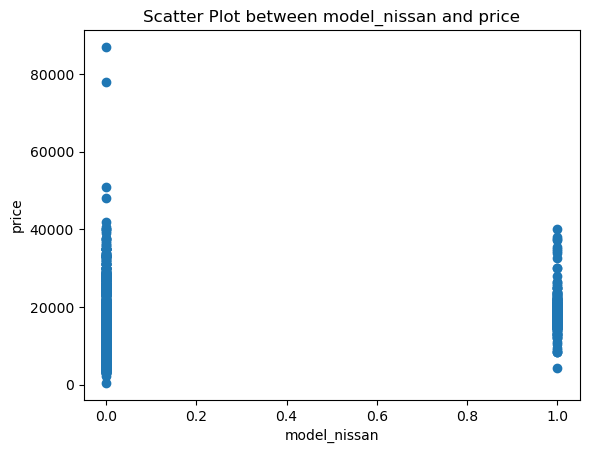

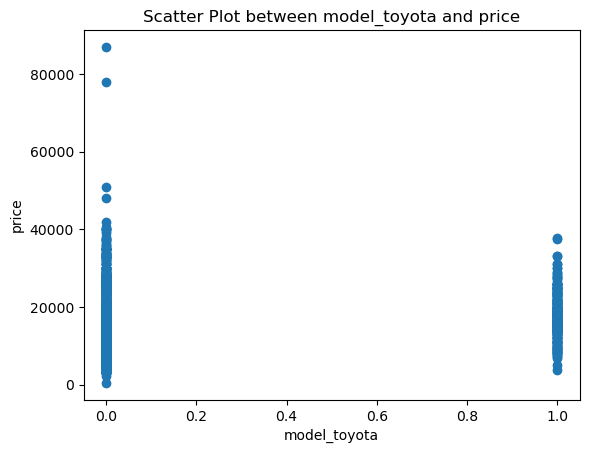

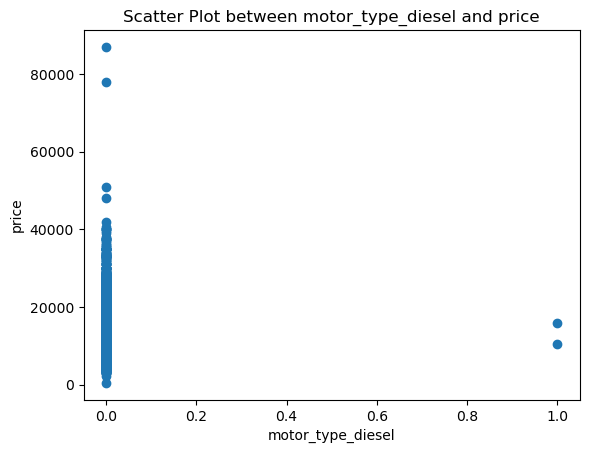

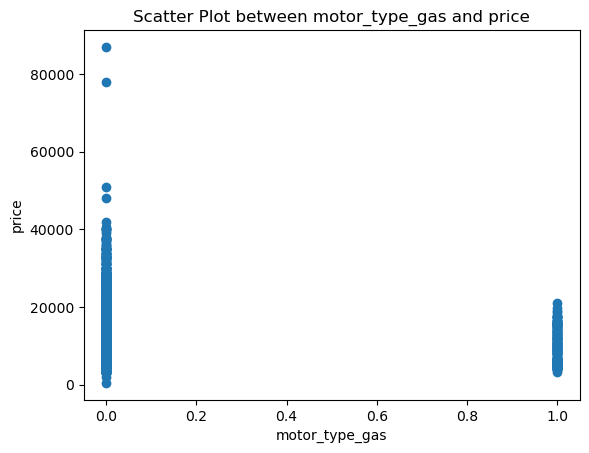

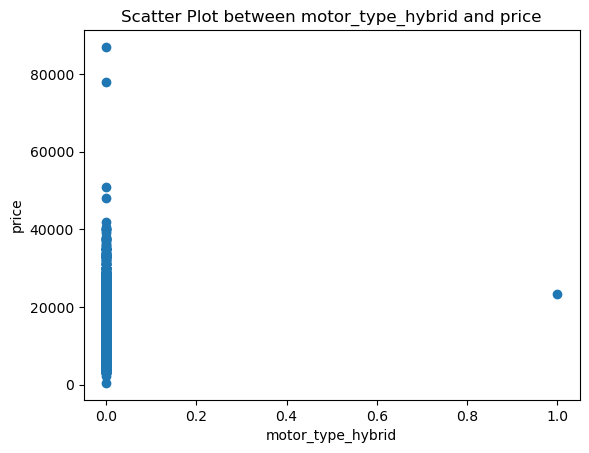

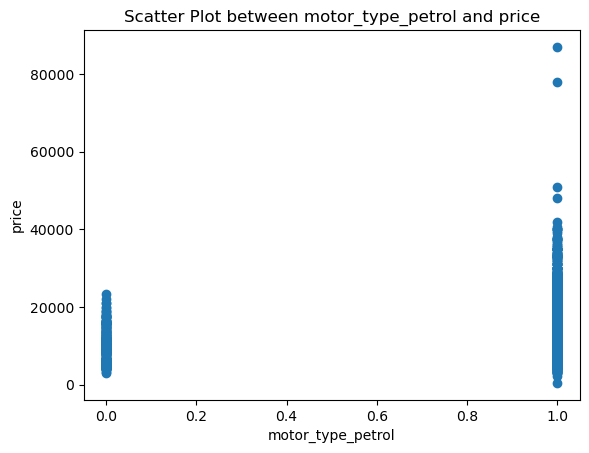

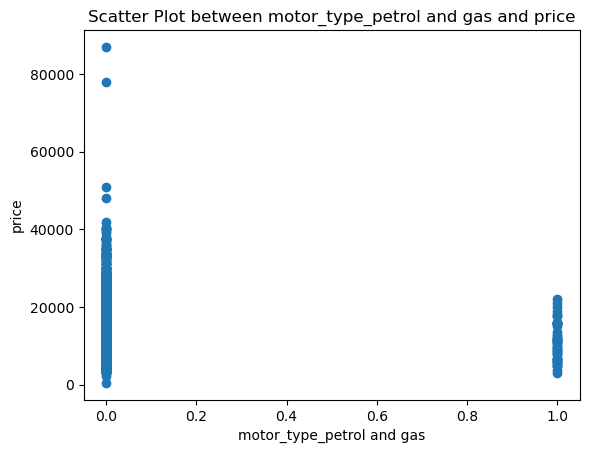

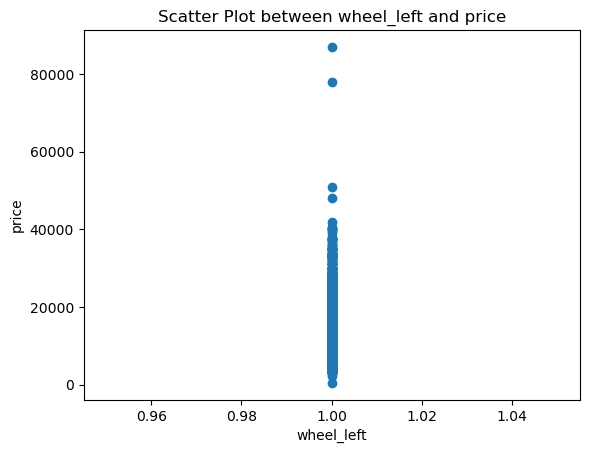

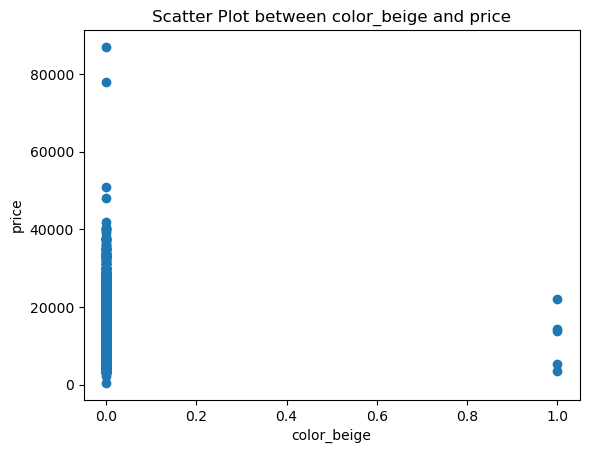

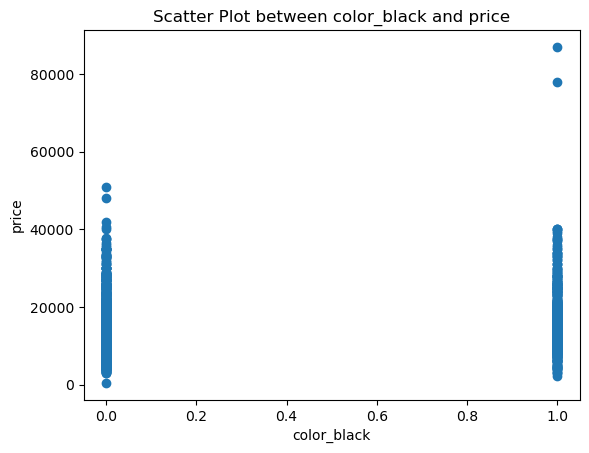

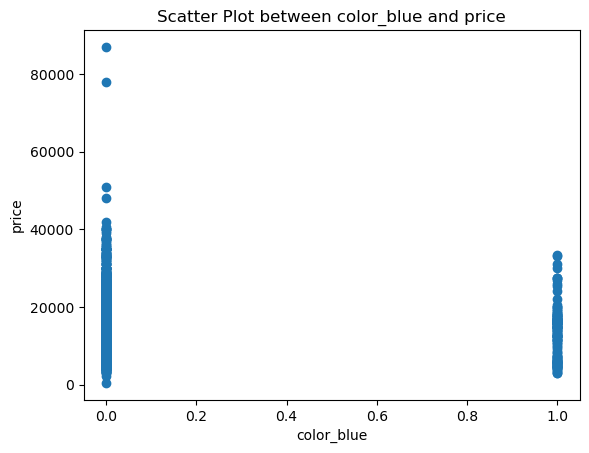

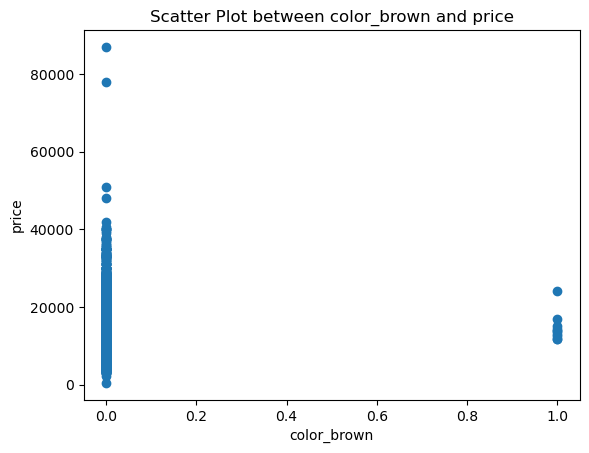

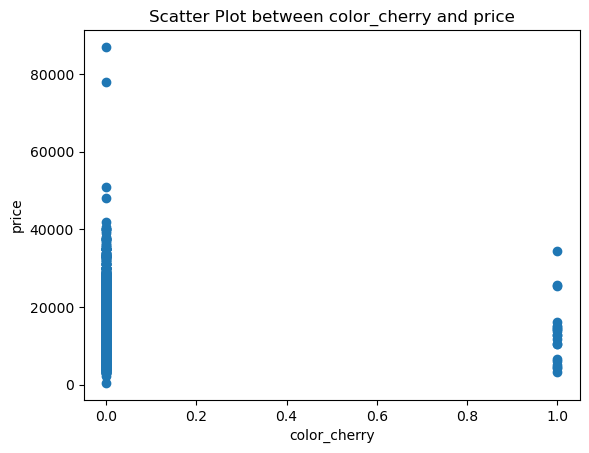

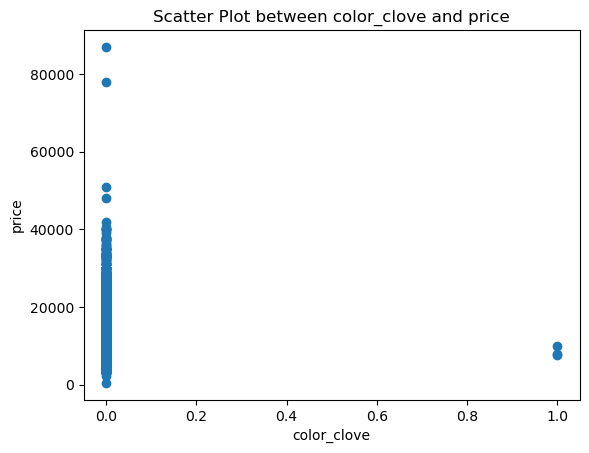

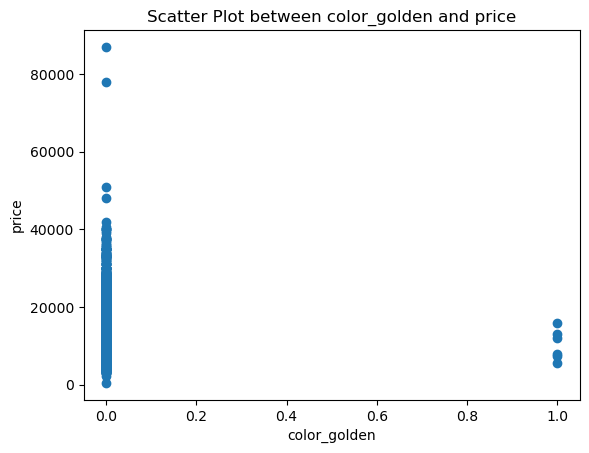

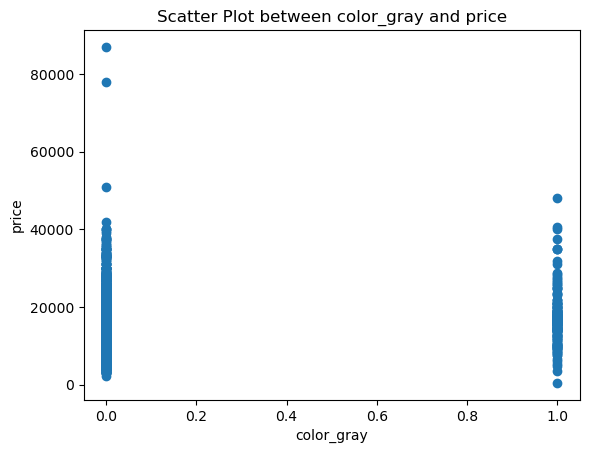

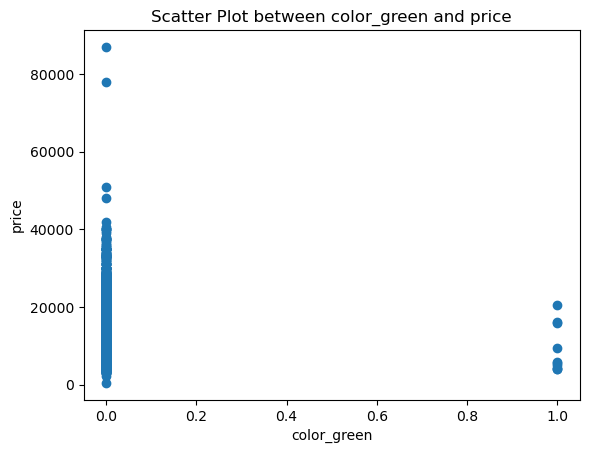

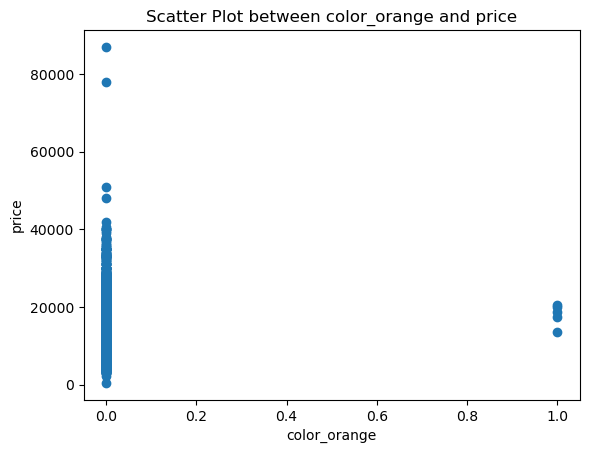

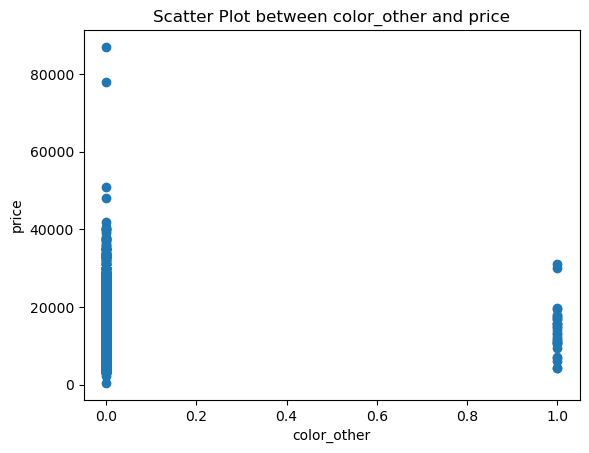

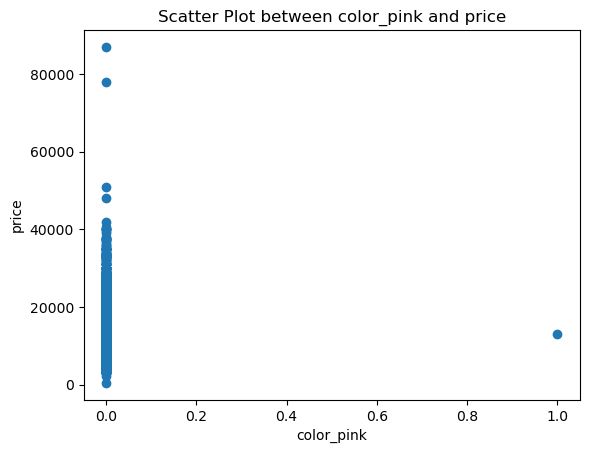

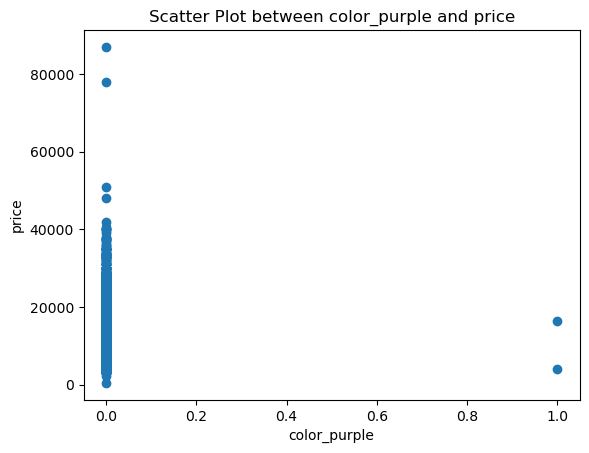

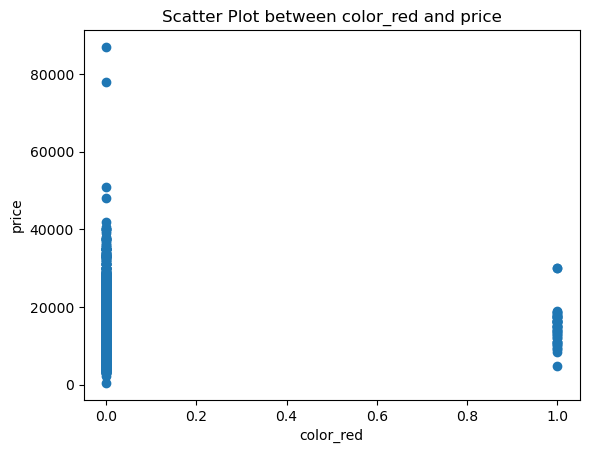

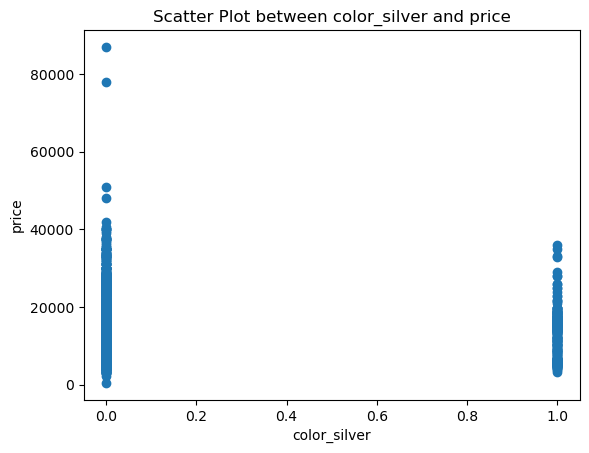

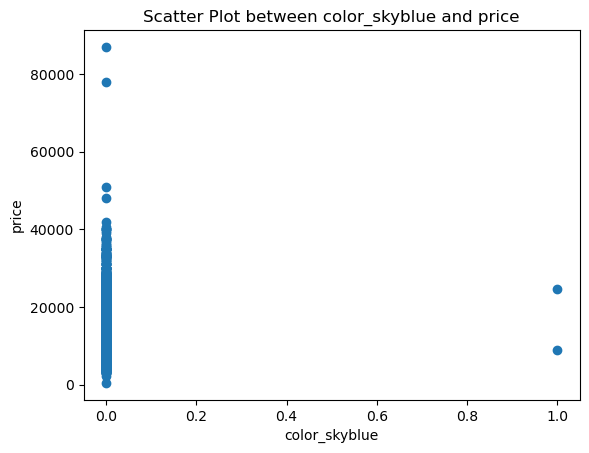

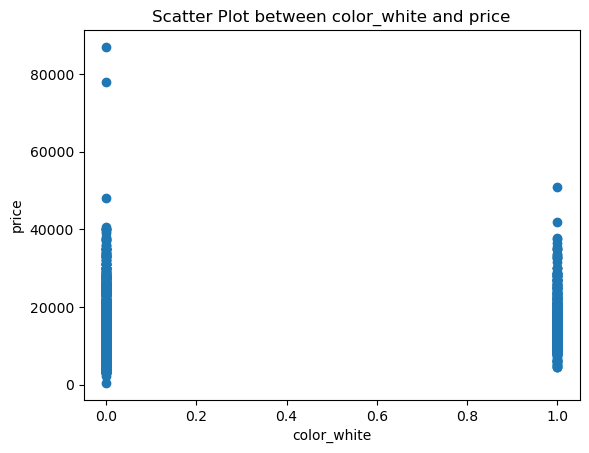

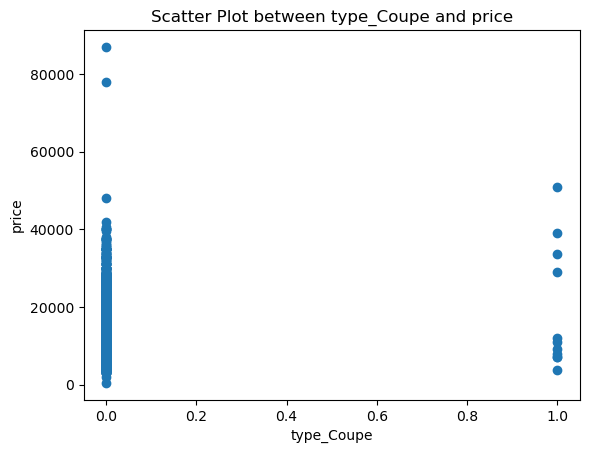

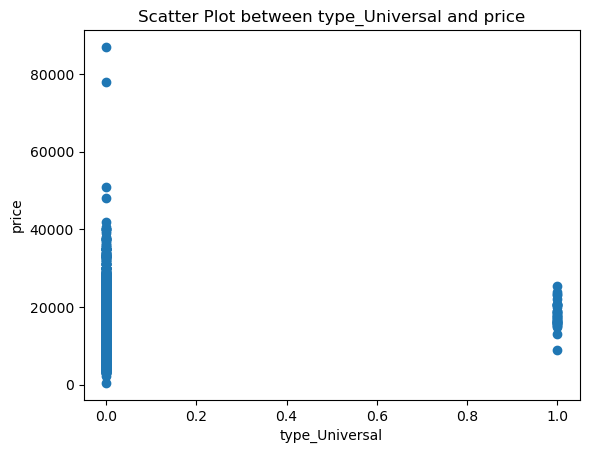

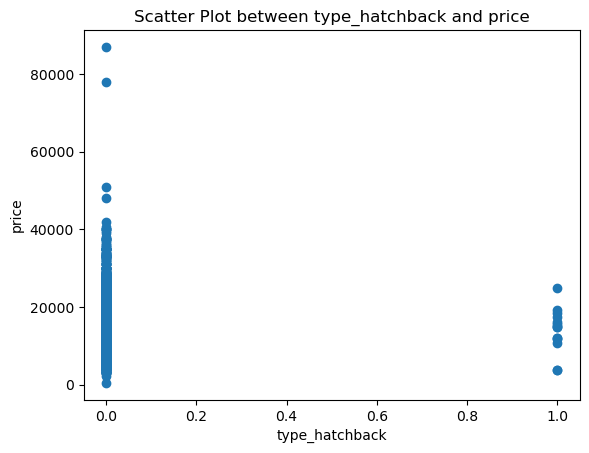

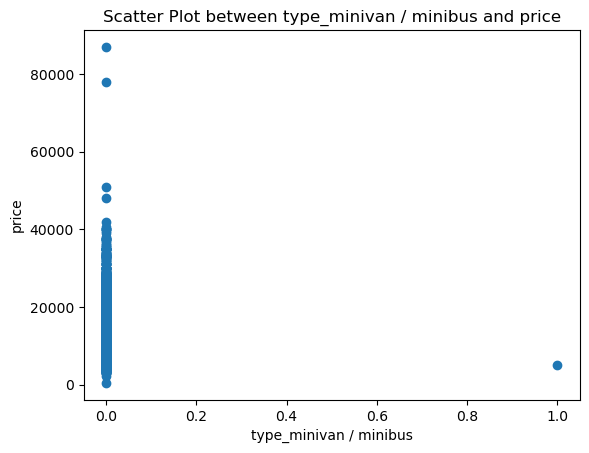

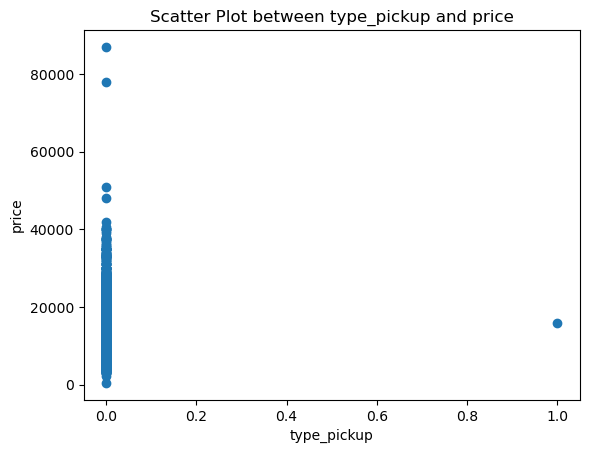

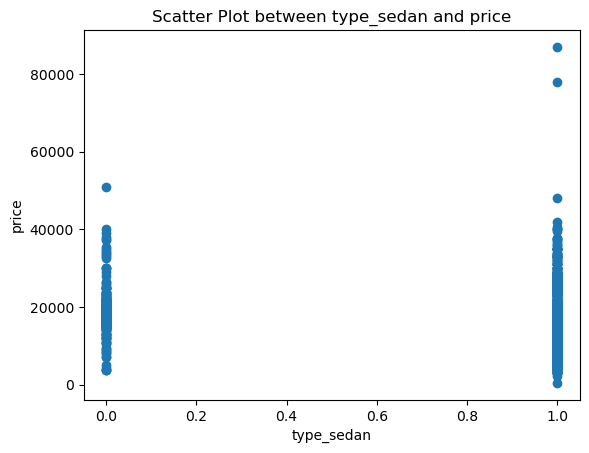

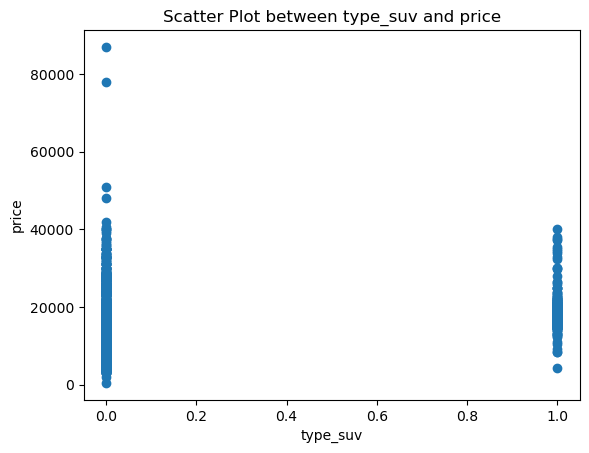

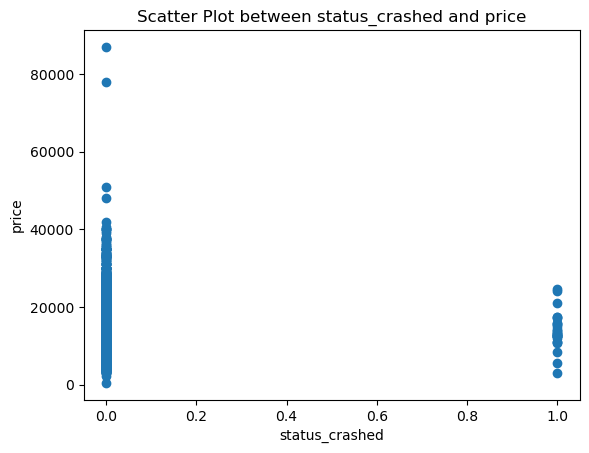

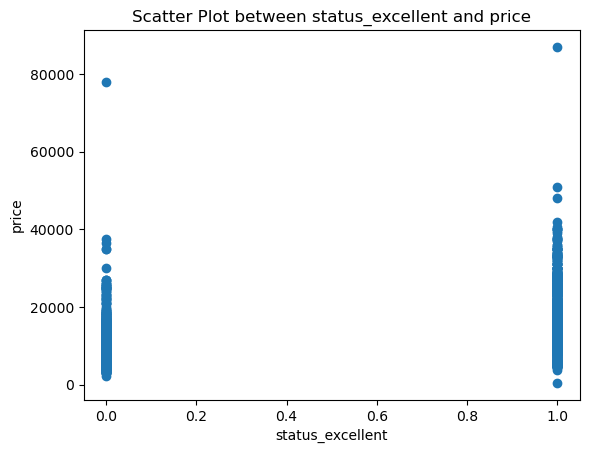

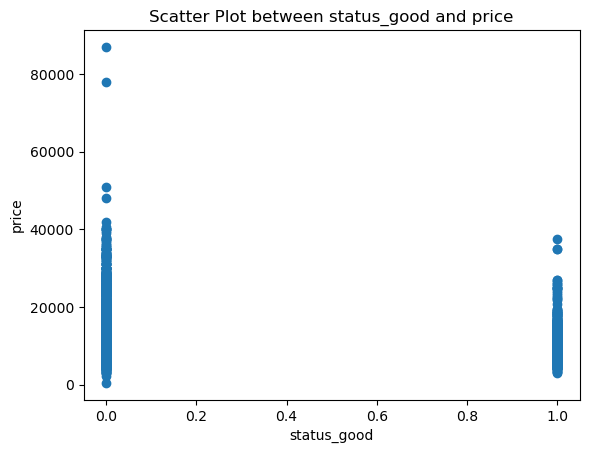

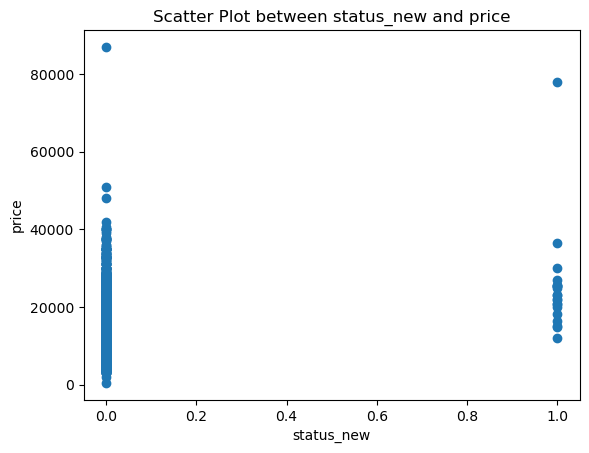

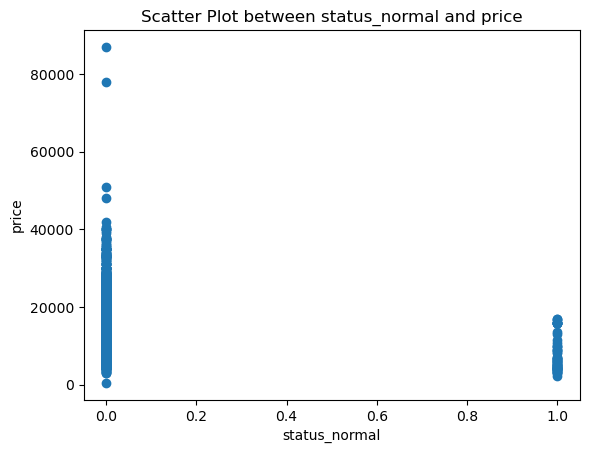

In [250]:
for i in X_combined.columns:
    draw_scatter(i, X_combined, y_combined)

# 5. Modelling

In [251]:
X_train

,year,running,motor_volume,log_running,running_per_motor,running_per_year,model_hyundai,model_kia,model_mercedes-benz,model_nissan,...,type_hatchback,type_minivan / minibus,type_pickup,type_sedan,type_suv,status_crashed,status_excellent,status_good,status_new,status_normal
63,2014,92215.000,2.0,11.431889,5.715944,1.143189,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
812,2022,4667.086,2.0,8.448504,4.224252,4.224252,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1156,2017,71000.000,2.0,11.170449,5.585225,1.595778,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1043,2002,260000.000,2.0,12.468441,6.234220,0.566747,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1589,2011,145000.000,1.8,11.884496,6.602498,0.914192,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,2018,83000.000,2.0,11.326608,5.663304,1.887768,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
1294,2017,70000.000,2.0,11.156265,5.578132,1.593752,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
860,2011,120000.000,2.0,11.695255,5.847628,0.899635,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1459,2017,130000.000,2.0,11.775297,5.887649,1.682185,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [252]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()
y_train1 = y_train.copy()
y_test1 = y_test.copy()

In [253]:
current_year = 2024 
X_train1['car_age'] = current_year - X_train1['year']
X_test1["car_age"] = current_year - X_test1['year']

In [254]:
X_train1['mileage_category'] = (pd.cut(X_train1['running'], bins=[-1, 100, 200, 300, np.inf], labels=[0, 1, 2, 3])).astype(int)
X_test1['mileage_category'] = (pd.cut(X_test1['running'], bins=[-1, 100, 200, 300, np.inf], labels=[0, 1, 2, 3])).astype(int)

In [255]:
# X_train1 = X_train1[y_train1 <= 60000]
# y_train1 = y_train1[y_train1 <= 60000]

In [256]:
X_train1["age_squared"] = X_train1["car_age"]** 2
X_test1["age_squared"] = X_test1["car_age"] ** 2

In [257]:
X_train1['log_running'] = np.log1p(X_train1['running'])
X_test1['log_running'] = np.log1p(X_test1['running'])

In [258]:
# X_train1 = X_train1.drop([ "wheel", "motor_type", "type"], axis = 1)
# X_test1 = X_test1.drop(["wheel", "motor_type", "type"], axis = 1)

In [259]:
def transformX(X_combined):
    X_transformed = X_combined.copy()
    X_transformed["car_age"] = 2024 - X_transformed["year"]
    X_transformed["mileage_category"] = (pd.cut(X_transformed['running'], bins=[-1, 100, 200, 300, np.inf], labels=[0, 1, 2, 3])).astype(int)
    #X_transformed = X_transformed.drop([ "wheel", "motor_type", "type"], axis = 1)
    X_transformed["age_squared"] = X_transformed["car_age"]** 2
    X_transformed['log_running'] = np.log1p(X_transformed['running'])
    
    return X_transformed

In [260]:
models = {
    "Random Forest": RandomForestRegressor(n_jobs = -1, random_state = 42),
    "XGBReg": XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)
}
scores = {}
for name, model in models.items():
    # Fit each model to the data
    model.fit(X_train1, y_train1)
    y_pred = model.predict(X_test1)
    scores[name] = mean_absolute_error(y_test, y_pred)

In [261]:
scores

{'Random Forest': 2151.976997961264, 'XGBReg': 1989.591469627637}

In [262]:
scores

{'Random Forest': 2151.976997961264, 'XGBReg': 1989.591469627637}

In [263]:
%%capture
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {"n_estimators": np.arange(10, 100, 10),
          "max_depth": [None, 3, 5, 10],
          "min_samples_split": np.arange(2, 20, 2),
          "min_samples_leaf": np.arange(1, 20, 2),
          "max_features": [0.5, 1, "sqrt", "auto"]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1, random_state = 42),
                             param_distributions = rf_grid, cv = 5,n_iter = 20,
                             verbose = True)
rs_model.fit(X_train1, y_train1)

In [264]:
mean_absolute_error(y_test, rs_model.predict(X_test1))

1977.735293495105

In [265]:
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 10,
 'min_samples_leaf': 17,
 'max_features': 0.5,
 'max_depth': None}

In [266]:
mean_absolute_error(y_test, rs_model.predict(X_test1))

1977.735293495105

In [267]:
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 10,
 'min_samples_leaf': 17,
 'max_features': 0.5,
 'max_depth': None}

In [268]:
%%capture
model = RandomForestRegressor(n_estimators = 30,
 min_samples_split= 10,
 min_samples_leaf= 17,
 max_features= 0.5,
 max_depth= None)

my_X, my_Y = transformX(X_combined), y_combined
model.fit(my_X, my_Y)

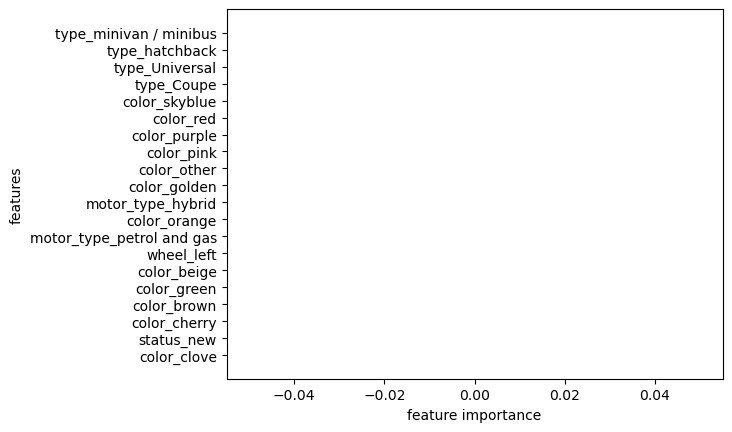

In [269]:
# Find feature importance of our best model

def plot_features(columns, importances, n = 20):
    my_df = (pd.DataFrame({"features": columns,
                          "feature_importances": importances}).sort_values("feature_importances", ascending = True)
                        .reset_index(drop = True))
    
    fig, ax = plt.subplots()
    ax.barh(my_df["features"][:n], my_df["feature_importances"][:n])
    ax.set_ylabel("features")
    ax.set_xlabel("feature importance")

plot_features(transformX(X_combined).columns, model.feature_importances_ )

In [270]:
param_distributions = {
    'n_estimators': range(50, 1001, 50), 
    'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3],
    'max_depth': range(2, 16),  
    'colsample_bytree': [i/10.0 for i in range(3, 11)], 
    'subsample': [i/10.0 for i in range(5, 11)],  
    'min_child_weight': range(1, 10), 
    'gamma': [i/10.0 for i in range(0, 6)],  
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],  
    'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100] 
}

grid_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                                 param_distributions=param_distributions,
                                 n_iter=10, 
                                 scoring='neg_mean_absolute_error',  
                                 cv=3,  
                                 verbose=2,  
                                 random_state=42, 
                                 n_jobs=-1)  

grid_search.fit(X_train1, y_train1)

print("Best parameters:", grid_search.best_params_)
print("Best mean absolute error (negated):", grid_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\minha\Desktop\my_proj1\env\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 100, 'n_estimators': 350, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best mean absolute error (negated): -2113.8303953885265


In [271]:
%%capture
xgboost = XGBRegressor(subsample = 0.7, reg_lambda = 1e-05, reg_alpha = 100, 
                       n_estimators = 300, min_child_weight = 8,
                       max_depth = 5, learning_rate = 0.02, 
                       gamma = 0.2, colsample_bytree = 1.0)

xgboost.fit(my_X, my_Y)

In [272]:
mean_absolute_error(y_test, xgboost.predict(X_test1))

1534.183857302418

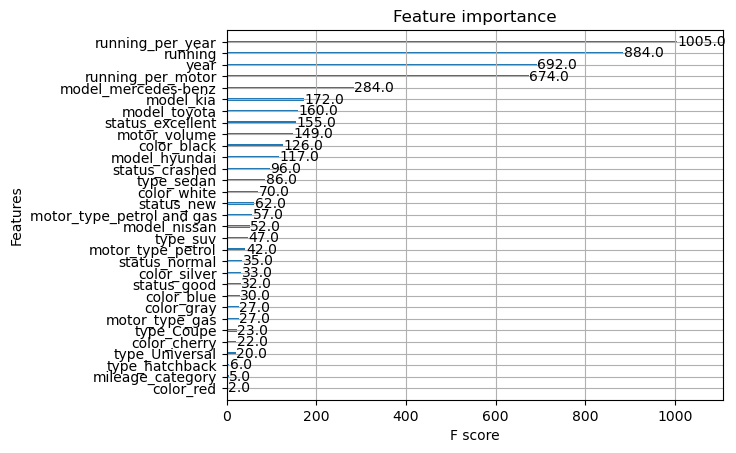

In [273]:
xgb.plot_importance(xgboost)
plt.show()


In [274]:
test_df = transformX(df_test).drop("Id", axis = 1)
test_df = test_df.reindex(columns=X_train1.columns, fill_value=0)

y_pred = model.predict(test_df)
result = pd.DataFrame(columns = ["Id", "price"])
result.Id = df_test.Id
result.price = y_pred
result

,Id,price
0,0,17689.245475
1,1,16344.923817
2,2,22679.778004
3,3,14458.651179
4,4,6682.965112
...,...,...
406,406,23363.965367
407,407,13926.239154
408,408,13639.633235
409,409,16647.928847


In [275]:
y_pred = xgboost.predict(test_df)
result = pd.DataFrame(columns = ["Id", "price"])
result.Id = df_test.Id
result.price = y_pred
result

,Id,price
0,0,17237.384766
1,1,16836.341797
2,2,23220.447266
3,3,14705.418945
4,4,7032.911133
...,...,...
406,406,26549.277344
407,407,14070.165039
408,408,14064.885742
409,409,16155.297852


In [276]:
result.to_csv('submission.csv',index=False)